In [1]:
import torch
from torch import nn
from torch import einsum
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LambdaLR
from einops.layers.torch import Rearrange

import os
from os import cpu_count
import json

from multiprocessing.pool import Pool
from multiprocessing import Manager

from progress.bar import ChargingBar

from functools import partial


from random import random, randint, choice

from einops import rearrange, repeat
from efficientnet_pytorch import EfficientNet

import cv2
import re
import numpy as np
from random import randint

import matplotlib.pyplot as plt
from PIL import Image

import uuid

from albumentations import Compose, RandomBrightnessContrast, \
    HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, \
    ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur, Rotate

from sklearn.utils.class_weight import compute_class_weight

import collections

# from utils import get_method, check_correct, resize, shuffle_dataset, get_n_params

import math
import yaml
import argparse
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
from albumentations import DualTransform, ImageOnlyTransform

def isotropically_resize_image(img, size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC):
    h, w = img.shape[:2]
    if max(w, h) == size:
        return img
    if w > h:
        scale = size / w
        h = h * scale
        w = size
    else:
        scale = size / h
        w = w * scale
        h = size
    interpolation = interpolation_up if scale > 1 else interpolation_down
    resized = cv2.resize(img, (int(w), int(h)), interpolation=interpolation)
    return resized

class IsotropicResize(DualTransform):
    def __init__(self, max_side, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC,
                 always_apply=False, p=1):
        super(IsotropicResize, self).__init__(always_apply, p)
        self.max_side = max_side
        self.interpolation_down = interpolation_down
        self.interpolation_up = interpolation_up

    def apply(self, img, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC, **params):
        return isotropically_resize_image(img, size=self.max_side, interpolation_down=interpolation_down,
                                          interpolation_up=interpolation_up)

    def apply_to_mask(self, img, **params):
        return self.apply(img, interpolation_down=cv2.INTER_NEAREST, interpolation_up=cv2.INTER_NEAREST, **params)

    def get_transform_init_args_names(self):
        return ("max_side", "interpolation_down", "interpolation_up")

In [3]:
import cv2
from albumentations import Compose, PadIfNeeded
import numpy as np
import os
import cv2
import torch
from statistics import mean

def transform_frame(image, image_size):
    transform_pipeline = Compose([
                IsotropicResize(max_side=image_size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
                PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_REPLICATE)
                ]
            )
    return transform_pipeline(image=image)['image']
    
    
def resize(image, image_size):
    try:
        return cv2.resize(image, dsize=(image_size, image_size))
    except:
        return []

def custom_round(values):
    result = []
    for value in values:
        if value > 0.55:
            result.append(1)
        else:
            result.append(0)
    return np.asarray(result)

def custom_video_round(preds):
    for pred_value in preds:
        if pred_value > 0.55:
            return pred_value
    return mean(preds)
        

# Original Code
'''
def get_method(video, data_path):
    methods = os.listdir(os.path.join(data_path, "manipulated_sequences"))
    methods.extend(os.listdir(os.path.join(data_path, "original_sequences")))
    methods.append("DFDC")
    methods.append("Original")
    selected_method = ""
    for method in methods:
        if method in video:
            selected_method = method
            break
    return selected_method
'''

# Modify for extracted faces, different dataset folder
def get_method(video, data_path):
    methods = os.listdir(data_path)
    selected_method = ""
    for method in methods:
        if method in video:
            selected_method = method
            break
    return selected_method


def shuffle_dataset(dataset):
  import random
  random.seed(4)
  random.shuffle(dataset)
  return dataset

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
    
def check_correct(preds, labels):
    preds = preds.cpu()
    labels = labels.cpu()
    preds = [np.asarray(torch.sigmoid(pred).detach().numpy()).round() for pred in preds]

    correct = 0
    positive_class = 0
    negative_class = 0
    for i in range(len(labels)):
        pred = int(preds[i])
        if labels[i] == pred:
            correct += 1
        if pred == 1:
            positive_class += 1
        else:
            negative_class += 1
    return correct, positive_class, negative_class

In [4]:
# def resize(image, image_size):
#     try:
#         return cv2.resize(image.astype(np.int16), dsize=(image_size, image_size))
#     except:
#         return []

In [5]:
# # cv2.resize(img, dsize=(3, 3))
# # img_rgb = img.convert('RGB')
# # img_arr = np.array(img_rgb)
# # img_tensor = torch.tensor(img_arr, dtype=torch.float64)
# t = np.array([[1, 2], [2, 3]])
# # cv2.resize(t.astype(np.int16) , dsize=(1, 1))
# resize(t, 3)

In [6]:
class Fruit(object):
    def __init__(self, name, price):
        self._name = name
        self._price = price

    def __add__(self, target):
        return self._price + target._price

    def __sub__(self, target):
        return self._price - target._price

    def __mul__(self, target):
        return self._price * target._price

    def __truediv__(self, target):
        return self._price / target._price


apple = Fruit("사과", 100000)
durian = Fruit("두리안", 50000)

print(apple + durian) # 150000

150000


In [7]:
torch.tensor([[1, 2, 2],[2, 2, 2],[2, 2, 3]]).chunk(3, dim=-1)

(tensor([[1],
         [2],
         [2]]),
 tensor([[2],
         [2],
         [2]]),
 tensor([[2],
         [2],
         [3]]))

In [8]:
a = torch.ones([1, 2, 3, 4])
b = torch.ones([1, 2, 4, 4])
einsum('a w i d, a w j d -> a w j i', a, b).shape

torch.Size([1, 2, 4, 3])

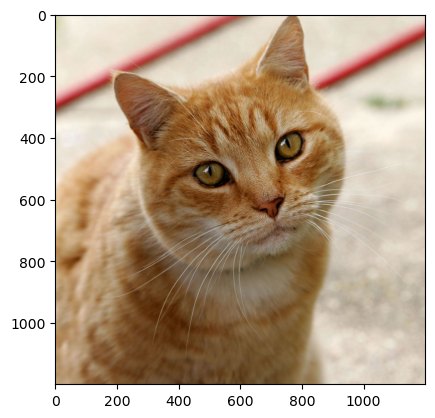

In [9]:
img = Image.open('./cat.jpg')
fig = plt.figure()
plt.imshow(img)

In [10]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [11]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [12]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        return self.net(x)

In [13]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False) # inner_dim * 3 : qkv inner_dim 3배

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1) # chunk(input, n, dim) : n개로 어떤 dimension으로 분할
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [14]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim=dim, hidden_dim=mlp_dim, dropout = 0))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

In [15]:
class EfficientViT(nn.Module): 
    def __init__(self, config, channels=512, selected_efficient_net = 0):
        super().__init__() 

        image_size = config['model']['image-size']
        patch_size = config['model']['patch-size']
        num_classes = config['model']['num-classes']
        dim = config['model']['dim']
        depth = config['model']['depth']
        heads = config['model']['heads']
        mlp_dim = config['model']['mlp-dim']
        emb_dim = config['model']['emb-dim']
        dim_head = config['model']['dim-head']
        dropout = config['model']['dropout']
        emb_dropout = config['model']['emb-dropout']

        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        
        self.selected_efficient_net = selected_efficient_net

        if selected_efficient_net == 0:
            self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        else:
            self.efficient_net = EfficientNet.from_pretrained('efficientnet-b7')
            checkpoint = torch.load("weights/final_999_DeepFakeClassifier_tf_efficientnet_b7_ns_0_23", map_location="cpu")
            state_dict = checkpoint.get("state_dict", checkpoint)
            self.efficient_net.load_state_dict({re.sub("^module.", "", k): v for k, v in state_dict.items()}, strict=False)
        
        ###---- check ----###
        for i in range(0, len(self.efficient_net._blocks)):
            for index, param in enumerate(self.efficient_net._blocks[i].parameters()):
                if i >= len(self.efficient_net._blocks)-3:
                    param.requires_grad = True
                else:
                    param.requires_grad = False
            
        num_patches = (7 // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(emb_dim, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size
        x = self.efficient_net.extract_features(img)
        #x = self.features(img)
        '''
        for im in img:
            image = im.cpu().detach().numpy()
            image = np.transpose(image, (1,2,0))
            cv2.imwrite("images/image"+str(randint(0,1000))+".png", image)
        
        x_scaled = []
        for idx, im in enumerate(x):
            im = im.cpu().detach().numpy()
            for patch_idx, patch in enumerate(im):
                patch = (255*(patch - np.min(patch))/np.ptp(patch)) 
                im[patch_idx] = patch
                #cv2.imwrite("patches/patches_"+str(idx)+"_"+str(patch_idx)+".png", patch)
            x_scaled.append(im)
        x = torch.tensor(x_scaled).cuda()   
        '''

        #x2 = self.features(img)
        y = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        #y2 = rearrange(x2, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        y = self.patch_to_embedding(y)
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, y), 1)
        shape=x.shape[0]
        x += self.pos_embedding[0:shape]
        x = self.dropout(x)
        x = self.transformer(x)
        x = self.to_cls_token(x[:, 0])
        
        return self.mlp_head(x)

## Cross Effiecient net

In [16]:
def exists(val):
    return val is not None

In [17]:
def default(val, d):
    return val if exists(val) else d

In [18]:
class Attention_cross(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_q = nn.Linear(dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, context = None, kv_include_self = False):
        b, n, _, h = *x.shape, self.heads
        context = default(context, x)

        if kv_include_self:
            context = torch.cat((x, context), dim = 1) # cross attention requires CLS token includes itself as key / value

        qkv = (self.to_q(x), *self.to_kv(context).chunk(2, dim = -1))
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

In [19]:
class Transformer_cross(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention_cross(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [20]:
class ProjectInOut(nn.Module):
    def __init__(self, dim_in, dim_out, fn):
        super().__init__()
        self.fn = fn

        need_projection = dim_in != dim_out
        self.project_in = nn.Linear(dim_in, dim_out) if need_projection else nn.Identity()
        self.project_out = nn.Linear(dim_out, dim_in) if need_projection else nn.Identity()

    def forward(self, x, *args, **kwargs):
        x = self.project_in(x)
        x = self.fn(x, *args, **kwargs)
        x = self.project_out(x)
        return x

In [21]:
class CrossTransformer(nn.Module):
    def __init__(self, sm_dim, lg_dim, depth, heads, dim_head, dropout):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                ProjectInOut(sm_dim, lg_dim, PreNorm(lg_dim, Attention_cross(lg_dim, heads = heads, dim_head = dim_head, dropout = dropout))),
                ProjectInOut(lg_dim, sm_dim, PreNorm(sm_dim, Attention_cross(sm_dim, heads = heads, dim_head = dim_head, dropout = dropout)))
            ]))

    def forward(self, sm_tokens, lg_tokens):
        (sm_cls, sm_patch_tokens), (lg_cls, lg_patch_tokens) = map(lambda t: (t[:, :1], t[:, 1:]), (sm_tokens, lg_tokens))

        for sm_attend_lg, lg_attend_sm in self.layers:
            sm_cls = sm_attend_lg(sm_cls, context = lg_patch_tokens, kv_include_self = True) + sm_cls
            lg_cls = lg_attend_sm(lg_cls, context = sm_patch_tokens, kv_include_self = True) + lg_cls

        sm_tokens = torch.cat((sm_cls, sm_patch_tokens), dim = 1)
        lg_tokens = torch.cat((lg_cls, lg_patch_tokens), dim = 1)
        return sm_tokens, lg_tokens

In [22]:
class MultiScaleEncoder(nn.Module):
    def __init__(
        self,
        *,
        depth,
        sm_dim,
        lg_dim,
        sm_enc_params,
        lg_enc_params,
        cross_attn_heads,
        cross_attn_depth,
        cross_attn_dim_head = 64,
        dropout = 0.
    ):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Transformer_cross(dim = sm_dim, dropout = dropout, **sm_enc_params),
                Transformer_cross(dim = lg_dim, dropout = dropout, **lg_enc_params),
                CrossTransformer(sm_dim = sm_dim, lg_dim = lg_dim, depth = cross_attn_depth, heads = cross_attn_heads, dim_head = cross_attn_dim_head, dropout = dropout)
            ]))

    def forward(self, sm_tokens, lg_tokens):
        for sm_enc, lg_enc, cross_attend in self.layers:
            sm_tokens, lg_tokens = sm_enc(sm_tokens), lg_enc(lg_tokens)
            sm_tokens, lg_tokens = cross_attend(sm_tokens, lg_tokens)

        return sm_tokens, lg_tokens

In [23]:
# class ImageEmbedder(nn.Module):
#     def __init__(
#         self,
#         *,
#         dim,
#         image_size,
#         patch_size,
#         dropout = 0.,
#         efficient_block = 8,
#         channels
#     ):
#         super().__init__()
#         assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
#         self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
# #         self.efficient_net.delete_blocks(efficient_block)
#         self.efficient_block = efficient_block
        
#         for index, (name, param) in enumerate(self.efficient_net.named_parameters()):
#             param.requires_grad = True
                
#         self.patch_size = patch_size
#         num_patches = (image_size // patch_size) ** 2
#         patch_dim = channels * patch_size ** 2
#         self.to_patch_embedding = nn.Sequential(
#             Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
#             nn.Linear(patch_dim, dim),
#         )
      
#         self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
#         self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, img):
#         x = self.efficient_net.extract_features_at_block(img, self.efficient_block)
#         '''
#         x_scaled = []
#         for idx, im in enumerate(x):
#             im = im.cpu().detach().numpy()
#             for patch_idx, patch in enumerate(im):
#                 patch = 2.*(patch - np.min(patch))/np.ptp(patch)-1
#                 im[patch_idx] = patch
               
#             x_scaled.append(im)
#         x = torch.tensor(x_scaled).cuda()    
#         '''
#         #x = torch.tensor(x).cuda()
#         '''
#         for idx, im in enumerate(x):
#             im = im.cpu().detach().numpy()
#             for patch_idx, patch in enumerate(im):
#                 cv2.imwrite("patches/patches_"+str(idx)+"_"+str(patch_idx)+".png", patch)
#         '''
#         x = self.to_patch_embedding(x)
#         b, n, _ = x.shape

#         cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
#         x = torch.cat((cls_tokens, x), dim=1)
#         x += self.pos_embedding[:, :(n + 1)]

#         return self.dropout(x)

In [24]:
class CrossEfficientViT(nn.Module):
    def __init__(
        self,
        *,
        config
    ):
        super().__init__()
        image_size = config['model']['image-size']
        num_classes = config['model']['num-classes'] 
        sm_dim = config['model']['sm-dim']
        sm_channels = config['model']['sm-channels']
        lg_dim = config['model']['lg-dim']
        lg_channels = config['model']['lg-channels']         
        sm_patch_size = config['model']['sm-patch-size']
        sm_enc_depth = config['model']['sm-enc-depth'] 
        sm_enc_heads = config['model']['sm-enc-heads']
        sm_enc_mlp_dim = config['model']['sm-enc-mlp-dim']
        sm_enc_dim_head = config['model']['sm-enc-dim-head']
        lg_patch_size = config['model']['lg-patch-size']
        lg_enc_depth = config['model']['lg-enc-depth'] 
        lg_enc_mlp_dim = config['model']['lg-enc-mlp-dim']
        lg_enc_heads = config['model']['lg-enc-heads']
        lg_enc_dim_head = config['model']['lg-enc-dim-head']
        cross_attn_depth = config['model']['cross-attn-depth']
        cross_attn_heads = config['model']['cross-attn-heads']
        cross_attn_dim_head = config['model']['cross-attn-dim-head']
        depth = config['model']['depth']
        dropout = config['model']['dropout']
        emb_dropout = config['model']['emb-dropout']



        self.sm_image_embedder = ImageEmbedder(dim = sm_dim, image_size = image_size, patch_size = sm_patch_size, dropout = emb_dropout, efficient_block = 16, channels=sm_channels)
        self.lg_image_embedder = ImageEmbedder(dim = lg_dim, image_size = image_size, patch_size = lg_patch_size, dropout = emb_dropout, efficient_block = 1, channels=lg_channels)

        self.multi_scale_encoder = MultiScaleEncoder(
            depth = depth,
            sm_dim = sm_dim,
            lg_dim = lg_dim,
            cross_attn_heads = cross_attn_heads,
            cross_attn_dim_head = cross_attn_dim_head,
            cross_attn_depth = cross_attn_depth,
            sm_enc_params = dict(
                depth = sm_enc_depth,
                heads = sm_enc_heads,
                mlp_dim = sm_enc_mlp_dim,
                dim_head = sm_enc_dim_head
            ),
            lg_enc_params = dict(
                depth = lg_enc_depth,
                heads = lg_enc_heads,
                mlp_dim = lg_enc_mlp_dim,
                dim_head = lg_enc_dim_head
            ),
            dropout = dropout
        )

        self.sm_mlp_head = nn.Sequential(nn.LayerNorm(sm_dim), nn.Linear(sm_dim, num_classes))
        self.lg_mlp_head = nn.Sequential(nn.LayerNorm(lg_dim), nn.Linear(lg_dim, num_classes))

    def forward(self, img):
        sm_tokens = self.sm_image_embedder(img)
        lg_tokens = self.lg_image_embedder(img)

        sm_tokens, lg_tokens = self.multi_scale_encoder(sm_tokens, lg_tokens)

        sm_cls, lg_cls = map(lambda t: t[:, 0], (sm_tokens, lg_tokens))

        sm_logits = self.sm_mlp_head(sm_cls)
        lg_logits = self.lg_mlp_head(lg_cls)

        return sm_logits + lg_logits

In [25]:
class DeepFakesDataset(Dataset):
    def __init__(self, images, labels, image_size, mode='train'):
        self.x = images
        self.y = torch.from_numpy(labels)
        self.image_size = image_size
        self.mode = mode
        self.n_samples = images.shape[0]
        
    def create_train_transforms(self, size):
        return Compose([
            ImageCompression(quality_lower=60, quality_upper=100, p=0.2),
            GaussNoise(p=0.3),
            HorizontalFlip(),
            OneOf([
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
                IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
            ], p=1),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
            OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.4),
            ToGray(p=0.2),
            ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=5, border_mode=cv2.BORDER_CONSTANT, p=0.5),
        ])
    
    def create_val_transform(self, size):
        return Compose([
            IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
            PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
        ])

    def __getitem__(self, index):
        image = np.asarray(self.x[index])
        if self.mode == 'train':
            transform = self.create_train_transforms(self.image_size)
        else:
            transform = self.create_val_transform(self.image_size)
        
        unique  = uuid.uuid4()
        
        #cv2.imwrite("../dataset/augmented_frames/isotropic_augmentation/"+str(unique)+"_"+str(index)+"_original.png", image)
   
        image = transform(image=image)['image']
        
        #cv2.imwrite("../dataset/augmented_frames/isotropic_augmentation/"+str(unique)+"_"+str(index)+".png", image)
        
        return torch.tensor(image).float(), self.y[index]
    
    def __len__(self):
        return self.n_samples

In [26]:
# BASE_DIR = '../../deep_fakes/'
# DATA_DIR = os.path.join(BASE_DIR, "dataset")
# TRAINING_DIR = os.path.join(DATA_DIR, "training_set")
# VALIDATION_DIR = os.path.join(DATA_DIR, "validation_set")
# TEST_DIR = os.path.join(DATA_DIR, "test_set")
# MODELS_PATH = "models"
# METADATA_PATH = os.path.join(BASE_DIR, "data/metadata") # Folder containing all training metadata for DFDC dataset
# VALIDATION_LABELS_PATH = os.path.join(DATA_DIR, "dfdc_val_labels.csv")

BASE_DIR = '/media/khmoon/T7/DeepFakeDatasets/'
DATA_DIR = os.path.join(BASE_DIR, "faceforensics_MTCNN_Output")
TRAINING_DIR = os.path.join(DATA_DIR, "training_set")
VALIDATION_DIR = os.path.join(DATA_DIR, "validation_set")
TEST_DIR = os.path.join(DATA_DIR, "test_set")
MODELS_PATH = "./models"

In [27]:
def read_frames(video_path, train_dataset, validation_dataset):
    
    # Get the video label based on dataset selected
    #### method = get_method(video_path, DATA_DIR)
    method = get_method(video_path, TRAINING_DIR) #-sky-#
    if TRAINING_DIR in video_path:
        if "Original" in video_path:
            label = 0.
        elif "DFDC" in video_path:
            for json_path in glob.glob(os.path.join(METADATA_PATH, "*.json")):
                with open(json_path, "r") as f:
                    metadata = json.load(f)
                video_folder_name = os.path.basename(video_path)
                video_key = video_folder_name + ".mp4"
                if video_key in metadata.keys():
                    item = metadata[video_key]
                    label = item.get("label", None)
                    if label == "FAKE":
                        label = 1.         
                    else:
                        label = 0.
                    break
                else:
                    label = None
        else:
            label = 1.
        if label == None:
            print("NOT FOUND", video_path)
    else:
        if "Original" in video_path:
            label = 0.
        elif "DFDC" in video_path:
            val_df = pd.DataFrame(pd.read_csv(VALIDATION_LABELS_PATH))
            video_folder_name = os.path.basename(video_path)
            video_key = video_folder_name + ".mp4"
            label = val_df.loc[val_df['filename'] == video_key]['label'].values[0]
        else:
            label = 1.

    # Calculate the interval to extract the frames
    # min_video_frames = 30*1 for Real, 30*0.3=9 for Fake #-sky-#
    frames_number = len(os.listdir(video_path))
    if label == 0:
        min_video_frames = max(int(config['training']['frames-per-video'] * config['training']['rebalancing_real']),1) # Compensate unbalancing
    else:
        min_video_frames = max(int(config['training']['frames-per-video'] * config['training']['rebalancing_fake']),1)

    
    if VALIDATION_DIR in video_path:
        min_video_frames = int(max(min_video_frames/8, 2))
    frames_interval = int(frames_number / min_video_frames)
    frames_paths = os.listdir(video_path)
    frames_paths_dict = {}


    for path in frames_paths:
        for i in range(0,1):
            if "_" + str(i) in path:
                if i not in frames_paths_dict.keys():
                    frames_paths_dict[i] = [path]
                else:
                    frames_paths_dict[i].append(path)

    # Select only the frames at a certain interval
    if frames_interval > 0:
        for key in frames_paths_dict.keys():
            if len(frames_paths_dict) > frames_interval:
                frames_paths_dict[key] = frames_paths_dict[key][::frames_interval]
            
            frames_paths_dict[key] = frames_paths_dict[key][:min_video_frames]

    # Select N frames from the collected ones
    for key in frames_paths_dict.keys():
        for index, frame_image in enumerate(frames_paths_dict[key]):
            #image = transform(np.asarray(cv2.imread(os.path.join(video_path, frame_image))))
            image = cv2.imread(os.path.join(video_path, frame_image))
            if image is not None:
                if TRAINING_DIR in video_path:
                    train_dataset.append((image, label))
                else:
                    validation_dataset.append((image, label))

In [28]:
#  if __name__ == "__main__":
    
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--num_epochs', default=300, type=int,
#                         help='Number of training epochs.')
#     parser.add_argument('--workers', default=10, type=int,
#                         help='Number of data loader workers.')
#     parser.add_argument('--resume', default='', type=str, metavar='PATH',
#                         help='Path to latest checkpoint (default: none).')
#     parser.add_argument('--dataset', type=str, default='All', 
#                         help="Which dataset to use (Deepfakes|Face2Face|FaceShifter|FaceSwap|NeuralTextures|All)")
#     parser.add_argument('--max_videos', type=int, default=-1, 
#                         help="Maximum number of videos to use for training (default: all).")
#     parser.add_argument('--config', type=str, 
#                         help="Which configuration to use. See into 'config' folder.")
#     parser.add_argument('--efficient_net', type=int, default=0, 
#                         help="Which EfficientNet version to use (0 or 7, default: 0)")
#     parser.add_argument('--patience', type=int, default=5, 
#                         help="How many epochs wait before stopping for validation loss not improving.")
    
#     opt, _ = parser.parse_known_args()
#     opt.config = "architecture.yaml" #-sky-#
#     opt.patience = 15
#     print(opt)

#     with open(opt.config, 'r') as ymlfile:
#         print('loaded')
#         config = yaml.safe_load(ymlfile)
 
#     if opt.efficient_net == 0:
#         channels = 1280
#     else:
#         channels = 2560
        
#     model = EfficientViT(config=config, channels=channels, selected_efficient_net = opt.efficient_net)
#     model.train()
    
#     optimizer = torch.optim.SGD(model.parameters(), lr=config['training']['lr'], weight_decay=config['training']['weight-decay'])
#     scheduler = lr_scheduler.StepLR(optimizer, step_size=config['training']['step-size'], gamma=config['training']['gamma'])
#     starting_epoch = 0
#     if os.path.exists(opt.resume):
#         model.load_state_dict(torch.load(opt.resume))
#         starting_epoch = int(opt.resume.split("checkpoint")[1].split("_")[0]) + 1 # The checkpoint's file name format should be "checkpoint_EPOCH"
#     else:
#         print("No checkpoint loaded.")


#     print("Model Parameters:", get_n_params(model))
    
   
#     #READ DATASET
#     if opt.dataset != "All" and opt.dataset != "DFDC":
#         folders = ["Original", opt.dataset]
#     else:
#         folders = ["Original", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures"] #-sky-#
# #         folders = ["Original", "DFDC", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures"]

#     sets = [TRAINING_DIR, VALIDATION_DIR]

#     paths = []
#     for dataset in sets:
#         for folder in folders:
#             subfolder = os.path.join(dataset, folder)
#             for index, video_folder_name in enumerate(os.listdir(subfolder)):
#                 if index == opt.max_videos:
#                     break

#                 if os.path.isdir(os.path.join(subfolder, video_folder_name)):
#                     paths.append(os.path.join(subfolder, video_folder_name))

#     mgr = Manager()
#     train_dataset = mgr.list()
#     validation_dataset = mgr.list()
    
#     print(opt, train_dataset, mgr, validation_dataset)

#     with Pool(processes=opt.workers) as p:
#         with tqdm(total=len(paths)) as pbar:
#             for v in p.imap_unordered(partial(read_frames, train_dataset=train_dataset, validation_dataset=validation_dataset),paths):
#                 pbar.update()
    
#     train_samples = len(train_dataset)
#     train_dataset = shuffle_dataset(train_dataset)
#     validation_samples = len(validation_dataset)
#     validation_dataset = shuffle_dataset(validation_dataset)

#     print("Train images:", len(train_dataset), "\t", "Validation images:", len(validation_dataset))
#     print("__TRAINING STATS__")
#     train_counters = collections.Counter(image[1] for image in train_dataset)
#     print(train_counters)
    
#     class_weights = train_counters[0] / train_counters[1]
#     print("Weights", class_weights)

#     print("__VALIDATION STATS__")
#     val_counters = collections.Counter(image[1] for image in validation_dataset)
#     print(val_counters)
#     print("___________________")

#     loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights]))

#     # Create the data loaders
#     validation_labels = np.asarray([row[1] for row in validation_dataset])
#     labels = np.asarray([row[1] for row in train_dataset])

#     train_dataset = DeepFakesDataset(np.asarray([row[0] for row in train_dataset], dtype=object), labels, config['model']['image-size'])
#     dl = torch.utils.data.DataLoader(train_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
#                                  batch_sampler=None, num_workers=opt.workers, collate_fn=None,
#                                  pin_memory=False, drop_last=False, timeout=0,
#                                  worker_init_fn=None, prefetch_factor=2,
#                                  persistent_workers=False)
#     del train_dataset

#     validation_dataset = DeepFakesDataset(np.asarray([row[0] for row in validation_dataset], dtype=object), validation_labels, config['model']['image-size'], mode='validation')
#     val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
#                                     batch_sampler=None, num_workers=opt.workers, collate_fn=None,
#                                     pin_memory=False, drop_last=False, timeout=0,
#                                     worker_init_fn=None, prefetch_factor=2,
#                                     persistent_workers=False)
#     del validation_dataset

# #     '''
# #     train_images = np.asarray([row[0] for row in train_dataset])
# #     train_dataset = DeepFakesDataset(train_images, labels, config['model']['image-size'])
# #     dl = torch.utils.data.DataLoader(train_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
# #                                  batch_sampler=None, num_workers=opt.workers, collate_fn=None,
# #                                  pin_memory=False, drop_last=False, timeout=0,
# #                                  worker_init_fn=None, prefetch_factor=2,
# #                                  persistent_workers=False)
# #     del train_dataset

# #     vaildation_images = np.asarray([row[0] for row in validation_dataset])
# #     validation_dataset = DeepFakesDataset(vaildation_images, validation_labels, config['model']['image-size'], mode='validation')
# #     val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
# #                                     batch_sampler=None, num_workers=opt.workers, collate_fn=None,
# #                                     pin_memory=False, drop_last=False, timeout=0,
# #                                     worker_init_fn=None, prefetch_factor=2,
# #                                     persistent_workers=False)
# #     del validation_dataset    
# #     '''
    
#     model = model.cuda()
#     counter = 0
#     not_improved_loss = 0
#     previous_loss = math.inf
    
#     # len(dl)=1238, bs=32, len(val_dl)=69
#     starting_epoch = 0  #### Remove after code check
#     opt.num_epochs = 1  #### Remove after code check

#     for t in range(starting_epoch, opt.num_epochs + 1):
# #         if not_improved_loss == opt.patience:
# #             break
#         counter = 0

#         total_loss = 0
#         total_val_loss = 0
        
#         bar = ChargingBar('EPOCH #' + str(t), max=(len(dl)*config['training']['bs'])+len(val_dl))
#         train_correct = 0
#         positive = 0
#         negative = 0
#         for index, (images, labels) in enumerate(dl):
#             images = np.transpose(images, (0, 3, 1, 2))
#             labels = labels.unsqueeze(1)
#             images = images.cuda()
            
#             y_pred = model(images)
#             y_pred = y_pred.cpu()
            
#             loss = loss_fn(y_pred, labels)
        
#             corrects, positive_class, negative_class = check_correct(y_pred, labels)  
#             train_correct += corrects
#             positive += positive_class
#             negative += negative_class
#             optimizer.zero_grad()
            
#             loss.backward()
            
#             optimizer.step()
#             counter += 1
#             total_loss += round(loss.item(), 2)
            
#             if index%100 == 0: # Intermediate metrics print
#                 print(index, "\nLoss:", total_loss/counter, "Accuracy:",train_correct/(counter*config['training']['bs']), "Train 0s:", negative, "Train 1s:", positive)

#             for i in range(config['training']['bs']):
#                 bar.next()

#         val_correct = 0
#         val_positive = 0
#         val_negative = 0
#         val_counter = 0
#         train_correct /= train_samples
#         total_loss /= counter
#         for index, (val_images, val_labels) in enumerate(val_dl):
    
#             val_images = np.transpose(val_images, (0, 3, 1, 2))
            
#             val_images = val_images.cuda()
#             val_labels = val_labels.unsqueeze(1)
#             val_pred = model(val_images)
#             val_pred = val_pred.cpu()
#             val_loss = loss_fn(val_pred, val_labels)
#             total_val_loss += round(val_loss.item(), 2)
#             corrects, positive_class, negative_class = check_correct(val_pred, val_labels)
#             val_correct += corrects
#             val_positive += positive_class
#             val_counter += 1
#             val_negative += negative_class
#             bar.next()
            
#         scheduler.step()
#         bar.finish()
            
#         total_val_loss /= val_counter
#         val_correct /= validation_samples
#         if previous_loss <= total_val_loss:
#             print("Validation loss did not improved")
#             not_improved_loss += 1
#         else:
#             not_improved_loss = 0
        
#         previous_loss = total_val_loss
#         print("#" + str(t) + "/" + str(opt.num_epochs) + " loss:" +
#             str(total_loss) + " accuracy:" + str(train_correct) +" val_loss:" + str(total_val_loss) + " val_accuracy:" + str(val_correct) + " val_0s:" + str(val_negative) + "/" + str(np.count_nonzero(validation_labels == 0)) + " val_1s:" + str(val_positive) + "/" + str(np.count_nonzero(validation_labels == 1)))
    
#         if not os.path.exists(MODELS_PATH):
#             os.makedirs(MODELS_PATH)
#         torch.save(model.state_dict(), os.path.join(MODELS_PATH,  "efficientnetB"+str(opt.efficient_net)+"_checkpoint" + str(t) + "_" + opt.dataset))

In [29]:
!ls

'Deepfake detection using EfficientNet&VIT.ipynb'
 EfficientNetB7.ipynb
 EfficientNet_B0.ipynb
'Vision Transformer(VIT).ipynb'
 __pycache__
 architecture.yaml
 architecture2.yaml
 cat.jpg
 final_999_DeepFakeClassifier_tf_efficientnet_b7_ns_0_23
 is_GPU_available.ipynb
 models


In [30]:
def read_frames(video_path, train_dataset, validation_dataset):
    
    # Get the video label based on dataset selected
    method = get_method(video_path, DATA_DIR)
    if TRAINING_DIR in video_path:
        if "Original" in video_path:
            label = 0.
        elif "DFDC" in video_path:
            for json_path in glob.glob(os.path.join(METADATA_PATH, "*.json")):
                with open(json_path, "r") as f:
                    metadata = json.load(f)
                video_folder_name = os.path.basename(video_path)
                video_key = video_folder_name + ".mp4"
                if video_key in metadata.keys():
                    item = metadata[video_key]
                    label = item.get("label", None)
                    if label == "FAKE":
                        label = 1.         
                    else:
                        label = 0.
                    break
                else:
                    label = None
        else:
            label = 1.
        if label == None:
            print("NOT FOUND", video_path)
    else:
        if "Original" in video_path:
            label = 0.
        elif "DFDC" in video_path:
            val_df = pd.DataFrame(pd.read_csv(VALIDATION_LABELS_PATH))
            video_folder_name = os.path.basename(video_path)
            video_key = video_folder_name + ".mp4"
            label = val_df.loc[val_df['filename'] == video_key]['label'].values[0]
        else:
            label = 1.

    # Calculate the interval to extract the frames
    frames_number = len(os.listdir(video_path))
    if label == 0:
        min_video_frames = max(int(config['training']['frames-per-video'] * config['training']['rebalancing-real']),1) # Compensate unbalancing
    else:
        min_video_frames = max(int(config['training']['frames-per-video'] * config['training']['rebalancing-fake']),1)

    
    if VALIDATION_DIR in video_path:
        min_video_frames = int(max(min_video_frames/8, 2))
    frames_interval = int(frames_number / min_video_frames)
    frames_paths = os.listdir(video_path)
    frames_paths_dict = {}

    # Group the faces with the same index, reduce probabiity to skip some faces in the same video
    for path in frames_paths:
        for i in range(0,1):
            if "_" + str(i) in path:
                if i not in frames_paths_dict.keys():
                    frames_paths_dict[i] = [path]
                else:
                    frames_paths_dict[i].append(path)
    # Select only the frames at a certain interval
    if frames_interval > 0:
        for key in frames_paths_dict.keys():
            if len(frames_paths_dict) > frames_interval:
                frames_paths_dict[key] = frames_paths_dict[key][::frames_interval]
            
            frames_paths_dict[key] = frames_paths_dict[key][:min_video_frames]
    # Select N frames from the collected ones
    for key in frames_paths_dict.keys():
        for index, frame_image in enumerate(frames_paths_dict[key]):
            #image = transform(np.asarray(cv2.imread(os.path.join(video_path, frame_image))))
            image = cv2.imread(os.path.join(video_path, frame_image))
            if image is not None:
                if TRAINING_DIR in video_path:
                    train_dataset.append((image, label))
                else:
                    validation_dataset.append((image, label))

# Main body
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('--num_epochs', default=300, type=int,
                        help='Number of training epochs.')
    parser.add_argument('--workers', default=10, type=int,
                        help='Number of data loader workers.')
    parser.add_argument('--resume', default='', type=str, metavar='PATH',
                        help='Path to latest checkpoint (default: none).')
    parser.add_argument('--dataset', type=str, default='All', 
                        help="Which dataset to use (Deepfakes|Face2Face|FaceShifter|FaceSwap|NeuralTextures|All)")
    parser.add_argument('--max_videos', type=int, default=-1, 
                        help="Maximum number of videos to use for training (default: all).")
    parser.add_argument('--config', type=str, 
                        help="Which configuration to use. See into 'config' folder.")
    parser.add_argument('--efficient_net', type=int, default=0, 
                        help="Which EfficientNet version to use (0 or 7, default: 0)")
    parser.add_argument('--patience', type=int, default=5, 
                        help="How many epochs wait before stopping for validation loss not improving.")
    
    opt, _ = parser.parse_known_args()
    opt.config = "architecture2.yaml" #-sky-#
    print(opt)

    with open(opt.config, 'r') as ymlfile:
        config = yaml.safe_load(ymlfile)
 
    model = CrossEfficientViT(config=config)
    model.train()   
    
    optimizer = torch.optim.SGD(model.parameters(), lr=config['training']['lr'], weight_decay=config['training']['weight-decay'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['training']['step-size'], gamma=config['training']['gamma'])
    starting_epoch = 0
    if os.path.exists(opt.resume):
        model.load_state_dict(torch.load(opt.resume))
        starting_epoch = int(opt.resume.split("checkpoint")[1].split("_")[0]) + 1
    else:
        print("No checkpoint loaded.")


    print("Model Parameters:", get_n_params(model))
   
    #READ DATASET
    if opt.dataset != "All":
        folders = ["Original", opt.dataset]
    else:
        folders = ["Original", "Deepfakes", "Face2Face", "FaceSwap", "NeuralTextures"]
        #folders = ["Original", "DFDC", "Deepfakes", "Face2Face", "FaceShifter", "FaceSwap", "NeuralTextures"]

    sets = [TRAINING_DIR, VALIDATION_DIR]

    paths = []
    for dataset in sets:
        for folder in folders:
            subfolder = os.path.join(dataset, folder)
            for index, video_folder_name in enumerate(os.listdir(subfolder)):
                if index == opt.max_videos:
                    break
                if os.path.isdir(os.path.join(subfolder, video_folder_name)):
                    paths.append(os.path.join(subfolder, video_folder_name))
                
    mgr = Manager()
    train_dataset = mgr.list()
    validation_dataset = mgr.list()

    with Pool(processes=10) as p:
        with tqdm(total=len(paths)) as pbar:
            for v in p.imap_unordered(partial(read_frames, train_dataset=train_dataset, validation_dataset=validation_dataset),paths):
                pbar.update()

    train_samples = len(train_dataset)
    train_dataset = shuffle_dataset(train_dataset)
    validation_samples = len(validation_dataset)
    validation_dataset = shuffle_dataset(validation_dataset)

    # Print some useful statistics
    print("Train images:", len(train_dataset), "Validation images:", len(validation_dataset))
    print("__TRAINING STATS__")
    train_counters = collections.Counter(image[1] for image in train_dataset)
    print(train_counters)
    
    class_weights = train_counters[0] / train_counters[1]
    print("Weights", class_weights)

    print("__VALIDATION STATS__")
    val_counters = collections.Counter(image[1] for image in validation_dataset)
    print(val_counters)
    print("___________________")

    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weights]))

    # Create the data loaders
    validation_labels = np.asarray([row[1] for row in validation_dataset])
    labels = np.asarray([row[1] for row in train_dataset])

    train_dataset = DeepFakesDataset(np.asarray([row[0] for row in train_dataset]), labels, config['model']['image-size'])
    dl = torch.utils.data.DataLoader(train_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
                                 batch_sampler=None, num_workers=opt.workers, collate_fn=None,
                                 pin_memory=False, drop_last=False, timeout=0,
                                 worker_init_fn=None, prefetch_factor=2,
                                 persistent_workers=False)
    del train_dataset

    validation_dataset = DeepFakesDataset(np.asarray([row[0] for row in validation_dataset]), validation_labels, config['model']['image-size'], mode='validation')
    val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=config['training']['bs'], shuffle=True, sampler=None,
                                    batch_sampler=None, num_workers=opt.workers, collate_fn=None,
                                    pin_memory=False, drop_last=False, timeout=0,
                                    worker_init_fn=None, prefetch_factor=2,
                                    persistent_workers=False)
    del validation_dataset
    

    model = model.cuda()
    counter = 0
    not_improved_loss = 0
    previous_loss = math.inf

    # len(dl)=1238, bs=32, len(val_dl)=69
    starting_epoch = 0  #### Remove after code check
    opt.num_epochs = 1  #### Remove after code check

    for t in range(starting_epoch, opt.num_epochs + 1):
        if not_improved_loss == opt.patience:
            break
        counter = 0

        total_loss = 0
        total_val_loss = 0
        
        bar = ChargingBar('EPOCH #' + str(t), max=(len(dl)*config['training']['bs'])+len(val_dl))
        train_correct = 0
        positive = 0
        negative = 0
        for index, (images, labels) in enumerate(dl):
            images = np.transpose(images, (0, 3, 1, 2))
            labels = labels.unsqueeze(1)
            images = images.cuda()
            
            y_pred = model(images)
            y_pred = y_pred.cpu()
            loss = loss_fn(y_pred, labels)
        
            corrects, positive_class, negative_class = check_correct(y_pred, labels)  
            train_correct += corrects
            positive += positive_class
            negative += negative_class
            optimizer.zero_grad()
            
            loss.backward()

            optimizer.step()
            counter += 1
            total_loss += round(loss.item(), 2)
            for i in range(config['training']['bs']):
                bar.next()
             
            if index%100 == 0:
                print(index, "\nLoss: ", total_loss/counter, "Accuracy: ",train_correct/(counter*config['training']['bs']) ,"Train 0s: ", negative, "Train 1s:", positive)  

        val_counter = 0
        val_correct = 0
        val_positive = 0
        val_negative = 0
       
        train_correct /= train_samples
        total_loss /= counter
        for index, (val_images, val_labels) in enumerate(val_dl):
    
            val_images = np.transpose(val_images, (0, 3, 1, 2))
            
            val_images = val_images.cuda()
            val_labels = val_labels.unsqueeze(1)
            val_pred = model(val_images)
            val_pred = val_pred.cpu()
            val_loss = loss_fn(val_pred, val_labels)
            total_val_loss += round(val_loss.item(), 2)
            corrects, positive_class, negative_class = check_correct(val_pred, val_labels)
            val_correct += corrects
            val_positive += positive_class
            val_negative += negative_class
            val_counter += 1
            bar.next()
            
        scheduler.step()
        bar.finish()
        
        total_val_loss /= val_counter
        val_correct /= validation_samples
        if previous_loss <= total_val_loss:
            print("Validation loss did not improved")
            not_improved_loss += 1
        else:
            not_improved_loss = 0
        
        previous_loss = total_val_loss
        print("#" + str(t) + "/" + str(opt.num_epochs) + " loss:" +
            str(total_loss) + " accuracy:" + str(train_correct) +" val_loss:" + str(total_val_loss) + " val_accuracy:" + str(val_correct) + " val_0s:" + str(val_negative) + "/" + str(np.count_nonzero(validation_labels == 0)) + " val_1s:" + str(val_positive) + "/" + str(np.count_nonzero(validation_labels == 1)))
    
        if not os.path.exists(MODELS_PATH):
            os.makedirs(MODELS_PATH)
        torch.save(model.state_dict(), os.path.join(MODELS_PATH,  "efficientnet_checkpoint" + str(t) + "_" + opt.dataset))

Namespace(num_epochs=300, workers=10, resume='', dataset='All', max_videos=-1, config='architecture2.yaml', efficient_net=0, patience=5)
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
No checkpoint loaded.
Model Parameters: 101377610


100%|██████████████████████████████████████| 4000/4000 [00:19<00:00, 209.32it/s]


Train images: 39600 Validation images: 2200
__TRAINING STATS__
Counter({1.0: 21600, 0.0: 18000})
Weights 0.8333333333333334
__VALIDATION STATS__
Counter({1.0: 1600, 0.0: 600})
___________________


UnboundLocalError: local variable 'x' referenced before assignment